# 1. Data Processing

Unzip cropped images

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)
# !unzip "/content/gdrive/Shareddrives/CIS520/dataset/train_cropped.zip" -d "/content"
# !pip install transformers

Init imports & global consts

In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from transformers import ViTForImageClassification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image
from tqdm import tqdm

# Commons
# CSV_PATH_0 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class0_5.csv'
# CSV_PATH_1 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class1_5.csv'
# TEST_CSV_PATH = '/content/gdrive/Shareddrives/CIS520/dataSupersets/test_ImagesAndLabels.csv'
CSV_PATH_0 = 'content/trainDev_ImagesAndLabels_class0_50.csv'
CSV_PATH_1 = 'content/trainDev_ImagesAndLabels_class1_50.csv'
TEST_CSV_PATH = 'content/test_ImagesAndLabels.csv'
FOLDER_PATH = 'content/train_cropped/train_cropped/'
RES_WEIGHT_PATH = 'content/checkpoint/res_6.h5'
VIT_WEIGHT_PATH = 'content/checkpoint/vit_6.h5'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(8888)
# if not os.path.exists('checkpoint'): os.mkdir('checkpoint')

# Hyperparams
BATCH_SIZE = 32
N_EPOCHS = 10
MAX_PATIENCE = 2

In [2]:
def cls_head(input_size):
    # return nn.Linear(input_size, 2)
    return nn.Sequential(nn.Linear(input_size, 32),
                         nn.ReLU(inplace=True),
                         nn.Linear(32, 2))

Create Torch Dataset classes

In [3]:
class TrainSet(Dataset):
    def __init__(self, df, img_dir, transform):
        self.csv = df
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.csv)

    def __getitem__(self, i):
        return {'image': self.transform(Image.open(os.path.join(self.img_dir, self.csv.loc[i,'imageFileName']))),
                'label': torch.tensor(int(self.csv.loc[i,'label']))}

In [4]:
class TestSet(Dataset):
    def __init__(self, df, img_dir, transform):
        self.csv = df
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.csv)

    def __getitem__(self, i):
        return {'image': self.transform(Image.open(os.path.join(self.img_dir, self.csv.loc[i,'imageFileName'])))}

Concatenate & Shuffle 0&1 images together 

In [5]:
filelist_df = pd.concat([pd.read_csv(CSV_PATH_0), pd.read_csv(CSV_PATH_1)], axis=0).sample(frac=1).reset_index(drop=True)

FileNotFoundError: [Errno 2] No such file or directory: 'content/trainDev_ImagesAndLabels_class0_50.csv'

Train_val_test split

In [47]:
train_df = filelist_df.loc[:int(len(filelist_df)*0.8),:].reset_index(drop=True)
val_df =   filelist_df.loc[int(len(filelist_df)*0.8):,:].reset_index(drop=True)
test_df =  pd.read_csv(TEST_CSV_PATH)[:20000]

For image normalization, it is hasty to find mean and std for each image, so we will calculate the mean and std for the first 1000 images and keep them as the global mean and std for normalization.

In [48]:
# naive_transform = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.ToTensor()
# ])

# img_mean, img_std = torch.zeros(3), torch.zeros(3)
# for i in range(1000):
#     img = naive_transform(Image.open(os.path.join(FOLDER_PATH, filelist_df.loc[i,'imageFileName'])))
#     img_mean += img.mean([1,2])
#     img_std += img.std([1,2])
# img_mean /= 1000
# img_std /= 1000

# print(img_mean)
# print(img_std)

In case you need to normalize the original 32x32x3 images, here are the results:

In [49]:
# naive_transform = transforms.Compose([
#     transforms.ToTensor()
# ])

# img_mean, img_std = torch.zeros(3), torch.zeros(3)
# for i in range(1000):
#     img = naive_transform(Image.open(os.path.join(FOLDER_PATH, filelist_df.loc[i,'imageFileName'])))
#     img_mean += img.mean([1,2])
#     img_std += img.std([1,2])
# img_mean /= 1000
# img_std /= 1000

# print(img_mean)
# print(img_std)

Initialize dataloaders

In [50]:
img_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7032, 0.5392, 0.6966], std=[0.1505, 0.1641, 0.1318])
])

dataset = {
    'train': TrainSet(df=train_df, img_dir=FOLDER_PATH, transform=img_transform),
    'val':   TrainSet(df=val_df,   img_dir=FOLDER_PATH, transform=img_transform),
    'test':  TestSet( df=test_df,  img_dir=FOLDER_PATH, transform=img_transform)
}

dataloader = {
    'train': DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val':   DataLoader(dataset['val'],   batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'test':  DataLoader(dataset['test'],  batch_size=BATCH_SIZE)
}

# 2. ResNet50

Init model

In [11]:
def resnet50_model(weight_path=None):
    model = resnet50(pretrained=True).to(DEVICE)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = cls_head(2048).to(DEVICE)
    if weight_path: model.load_state_dict(torch.load(weight_path))
    return model

In [12]:
model = resnet50_model()

/home/toastedqu/miniconda3/envs/mrq/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/toastedqu/miniconda3/envs/mrq/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Init optimizer & loss

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

Init train process

In [14]:
def train(model, dataset=dataset, dataloader=dataloader, criterion=criterion, optimizer=optimizer, n_epochs=N_EPOCHS):
    # early-stopping on validation accuracy
    max_acc = -1
    patience = MAX_PATIENCE

    for epoch in range(n_epochs):
        start = time.time()
        print('Epoch {}/{}'.format(epoch+1, n_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
    
            running_loss = 0.0
            running_corrects = 0

            for d in tqdm(dataloader[phase]):
                inputs, labels = d['image'].to(DEVICE), d['label'].to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
    
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)

            epoch_loss = running_loss/len(dataset[phase])
            epoch_acc = running_corrects.double()/len(dataset[phase])
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # early-stopping
        if max_acc <= epoch_acc:
            max_acc = epoch_acc
            patience = MAX_PATIENCE
            print(f'Best model saved at Epoch {epoch+1}')
            torch.save(model.state_dict(), RES_WEIGHT_PATH)
        elif patience > 0:
            patience -= 1
        else:
            print('Early Stopping!')
            break

        end = time.time()
        print(f'Time: {end-start}')
    return model

Train

In [15]:
model = train(model)

Epoch 1/10
----------


100%|██████████| 1311/1311 [01:42<00:00, 12.83it/s]


train loss: 0.4924, acc: 0.7665


100%|██████████| 328/328 [00:24<00:00, 13.61it/s]


val loss: 0.4825, acc: 0.7770
Best model saved at Epoch 1
Time: 126.46711730957031
Epoch 2/10
----------


100%|██████████| 1311/1311 [01:37<00:00, 13.43it/s]


train loss: 0.4711, acc: 0.7786


100%|██████████| 328/328 [00:24<00:00, 13.48it/s]


val loss: 0.4480, acc: 0.7939
Best model saved at Epoch 2
Time: 122.11417174339294
Epoch 3/10
----------


100%|██████████| 1311/1311 [01:38<00:00, 13.35it/s]


train loss: 0.4598, acc: 0.7860


100%|██████████| 328/328 [00:23<00:00, 13.68it/s]


val loss: 0.4403, acc: 0.7977
Best model saved at Epoch 3
Time: 122.34077858924866
Epoch 4/10
----------


100%|██████████| 1311/1311 [01:36<00:00, 13.53it/s]


train loss: 0.4536, acc: 0.7909


100%|██████████| 328/328 [00:24<00:00, 13.56it/s]


val loss: 0.4476, acc: 0.7955
Time: 121.06442475318909
Epoch 5/10
----------


100%|██████████| 1311/1311 [01:39<00:00, 13.23it/s]


train loss: 0.4449, acc: 0.7965


100%|██████████| 328/328 [00:24<00:00, 13.54it/s]


val loss: 0.4401, acc: 0.8020
Best model saved at Epoch 5
Time: 123.49413180351257
Epoch 6/10
----------


100%|██████████| 1311/1311 [01:37<00:00, 13.43it/s]


train loss: 0.4384, acc: 0.7990


100%|██████████| 328/328 [00:23<00:00, 13.81it/s]


val loss: 0.4414, acc: 0.8025
Best model saved at Epoch 6
Time: 121.52158713340759
Epoch 7/10
----------


100%|██████████| 1311/1311 [01:40<00:00, 13.10it/s]


train loss: 0.4399, acc: 0.7987


100%|██████████| 328/328 [00:23<00:00, 13.72it/s]


val loss: 0.4336, acc: 0.8028
Best model saved at Epoch 7
Time: 124.15478157997131
Epoch 8/10
----------


100%|██████████| 1311/1311 [01:37<00:00, 13.41it/s]


train loss: 0.4387, acc: 0.7974


100%|██████████| 328/328 [00:23<00:00, 13.71it/s]


val loss: 0.4397, acc: 0.8000
Time: 121.6813714504242
Epoch 9/10
----------


100%|██████████| 1311/1311 [01:37<00:00, 13.47it/s]


train loss: 0.4347, acc: 0.8010


100%|██████████| 328/328 [00:24<00:00, 13.50it/s]


val loss: 0.4436, acc: 0.7974
Time: 121.63338875770569
Epoch 10/10
----------


100%|██████████| 1311/1311 [01:36<00:00, 13.58it/s]


train loss: 0.4308, acc: 0.8013


100%|██████████| 328/328 [00:24<00:00, 13.59it/s]

val loss: 0.4376, acc: 0.8017
Early Stopping!


Test

In [16]:
model = resnet50_model(RES_WEIGHT_PATH)

In [17]:
def test(model, y=test_df['label'].to_numpy(), dataset=dataset, dataloader=dataloader, criterion=criterion):
    model.eval()
    probs = []
    with torch.no_grad():
        for batch in tqdm(dataloader['test']):
            probs.append(model(batch["image"].to(DEVICE)))

    y_pred = torch.cat(probs, dim=0).argmax(dim=1).cpu().data.numpy()
    return y_pred

In [18]:
y_pred = test(model)

100%|██████████| 625/625 [00:39<00:00, 15.72it/s]


In [19]:
y = test_df['label'].to_numpy()

In [20]:
acc = accuracy_score(y, y_pred)
print(f'Accuracy: {acc}')

Accuracy: 0.81005


<AxesSubplot: >

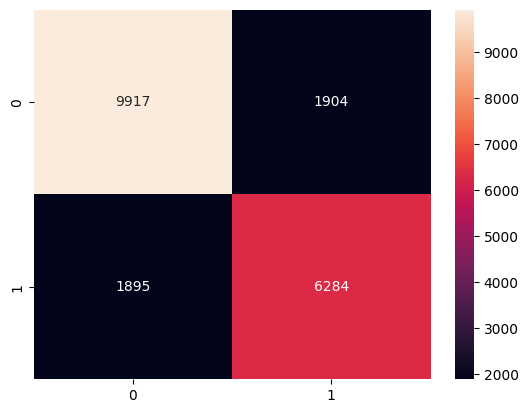

In [21]:
mat = confusion_matrix(y, y_pred)
sns.heatmap(mat, annot=True, fmt='g')

In [22]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     11821
           1       0.77      0.77      0.77      8179

    accuracy                           0.81     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.81      0.81      0.81     20000



# 3. ViT

Init model

In [30]:
def vit_model(weight_path=None):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(DEVICE)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = cls_head(768).to(DEVICE)
    if weight_path: model.load_state_dict(torch.load(weight_path))
    return model

In [31]:
model = vit_model()

Init optimizer & loss

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters())

Init train process

In [33]:
def train(model, dataset=dataset, dataloader=dataloader, criterion=criterion, optimizer=optimizer, n_epochs=N_EPOCHS):
    # early-stopping on validation accuracy
    max_acc = -1
    patience = MAX_PATIENCE

    for epoch in range(n_epochs):
        start = time.time()
        print('Epoch {}/{}'.format(epoch+1, n_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
    
            running_loss = 0.0
            running_corrects = 0

            for d in tqdm(dataloader[phase]):
                inputs, labels = d['image'].to(DEVICE), d['label'].to(DEVICE)
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
    
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)

            epoch_loss = running_loss/len(dataset[phase])
            epoch_acc = running_corrects.double()/len(dataset[phase])
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # early-stopping
        if max_acc <= epoch_acc:
            max_acc = epoch_acc
            patience = MAX_PATIENCE
            print(f'Best model saved at Epoch {epoch+1}')
            torch.save(model.state_dict(), VIT_WEIGHT_PATH)
        elif patience > 0:
            patience -= 1
        else:
            print('Early Stopping!')
            break

        end = time.time()
        print(f'Time: {end-start}')
    return model

Train

In [34]:
model = train(model)

Epoch 1/10
----------


100%|██████████| 1311/1311 [09:47<00:00,  2.23it/s]


train loss: 0.4084, acc: 0.8153


100%|██████████| 328/328 [02:27<00:00,  2.22it/s]


val loss: 0.4021, acc: 0.8220
Best model saved at Epoch 1
Time: 734.9945955276489
Epoch 2/10
----------


100%|██████████| 1311/1311 [09:43<00:00,  2.25it/s]


train loss: 0.3723, acc: 0.8357


100%|██████████| 328/328 [02:25<00:00,  2.25it/s]


val loss: 0.4086, acc: 0.8121
Time: 729.3653240203857
Epoch 3/10
----------


100%|██████████| 1311/1311 [09:36<00:00,  2.27it/s]


train loss: 0.3553, acc: 0.8443


100%|██████████| 328/328 [02:24<00:00,  2.27it/s]


val loss: 0.3608, acc: 0.8412
Best model saved at Epoch 3
Time: 721.8186783790588
Epoch 4/10
----------


100%|██████████| 1311/1311 [09:36<00:00,  2.27it/s]


train loss: 0.3438, acc: 0.8492


100%|██████████| 328/328 [02:25<00:00,  2.26it/s]


val loss: 0.3562, acc: 0.8447
Best model saved at Epoch 4
Time: 722.0056414604187
Epoch 5/10
----------


100%|██████████| 1311/1311 [09:37<00:00,  2.27it/s]


train loss: 0.3362, acc: 0.8539


100%|██████████| 328/328 [02:24<00:00,  2.27it/s]


val loss: 0.3558, acc: 0.8410
Time: 722.3165974617004
Epoch 6/10
----------


100%|██████████| 1311/1311 [09:36<00:00,  2.27it/s]


train loss: 0.3300, acc: 0.8562


100%|██████████| 328/328 [02:24<00:00,  2.26it/s]


val loss: 0.3621, acc: 0.8374
Time: 721.7201976776123
Epoch 7/10
----------


100%|██████████| 1311/1311 [09:36<00:00,  2.27it/s]


train loss: 0.3233, acc: 0.8604


100%|██████████| 328/328 [02:24<00:00,  2.27it/s]


val loss: 0.3556, acc: 0.8453
Best model saved at Epoch 7
Time: 721.514360666275
Epoch 8/10
----------


100%|██████████| 1311/1311 [09:36<00:00,  2.27it/s]


train loss: 0.3173, acc: 0.8624


100%|██████████| 328/328 [02:24<00:00,  2.27it/s]


val loss: 0.3544, acc: 0.8427
Time: 721.7226173877716
Epoch 9/10
----------


100%|██████████| 1311/1311 [09:37<00:00,  2.27it/s]


train loss: 0.3116, acc: 0.8647


100%|██████████| 328/328 [02:24<00:00,  2.27it/s]


val loss: 0.3593, acc: 0.8403
Time: 721.9965693950653
Epoch 10/10
----------


100%|██████████| 1311/1311 [09:37<00:00,  2.27it/s]


train loss: 0.3075, acc: 0.8668


100%|██████████| 328/328 [02:25<00:00,  2.25it/s]


val loss: 0.3558, acc: 0.8482
Best model saved at Epoch 10
Time: 723.5601649284363


Test

In [51]:
model = vit_model(VIT_WEIGHT_PATH)

In [52]:
def test(model, y=test_df['label'].to_numpy(), dataset=dataset, dataloader=dataloader, criterion=criterion):
    model.eval()
    probs = []
    with torch.no_grad():
        for batch in tqdm(dataloader['test']):
            probs.append(model(batch["image"].to(DEVICE)).logits)

    y_pred = torch.cat(probs, dim=0).argmax(dim=1).cpu().data.numpy()
    return y_pred                               

In [53]:
y_pred = test(model)

100%|██████████| 625/625 [02:21<00:00,  4.42it/s]


In [54]:
y = test_df['label'].to_numpy()

In [55]:
acc = accuracy_score(y, y_pred)
print(f'Accuracy: {acc}')

Accuracy: 0.8549


<AxesSubplot: >

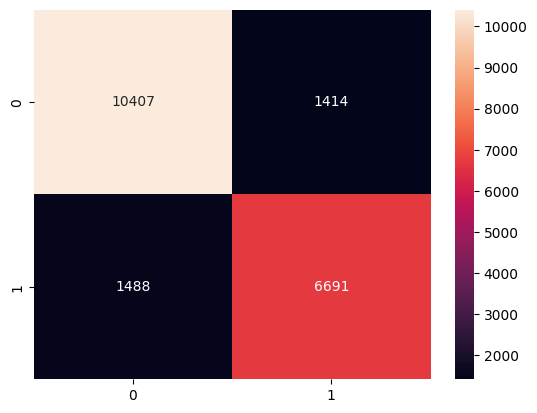

In [56]:
mat = confusion_matrix(y, y_pred)
sns.heatmap(mat, annot=True, fmt='g')

In [57]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88     11821
           1       0.83      0.82      0.82      8179

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000



# Draft

In [ ]:
# plt.rcParams["savefig.bbox"] = 'tight'


# def show(imgs):
#     fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
#     for i, img in enumerate(imgs):
#         img = T.ToPILImage()(img.to('cpu'))
#         axs[0, i].imshow(np.asarray(img))
#         axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
# img1 = T.ToTensor()(Image.open(os.path.join(FOLDER_PATH, filelist[10])))
# img2 = T.ToTensor()(Image.open(os.path.join(FOLDER_PATH, filelist[50])))
# show([img1, img2])

In [ ]:
# plt.rcParams["savefig.bbox"] = 'tight'
# torch.manual_seed(8888)
# FOLDER_PATH = '/content/Real-ESRGAN/results/'

# def show(imgs):
#     fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
#     for i, img in enumerate(imgs):
#         img = T.ToPILImage()(img.to('cpu'))
#         axs[0, i].imshow(np.asarray(img))
#         axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
# img1 = T.ToTensor()(Image.open('/content/Real-ESRGAN/results/00001b2b5609af42ab0ab276dd4cd41c3e7745b5_out.png'))
# img2 = T.ToTensor()(Image.open('/content/train_cropped_png/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.png'))
# show([img2, img1])

In [ ]:
# img2.size()

In [ ]:
# img1.size()

In [ ]:
# len(os.listdir('/content/train_cropped_png/'))

In [ ]:
# plt.rcParams["savefig.bbox"] = 'tight'
# torch.manual_seed(8888)
# FOLDER_PATH = '/content/Real-ESRGAN/results/'

# def show(imgs):
#     fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
#     for i, img in enumerate(imgs):
#         img = T.ToPILImage()(img.to('cpu'))
#         axs[0, i].imshow(np.asarray(img))
#         axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
# img1 = T.ToTensor()(Image.open('/content/train_cropped/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif'))
# img2 = T.ToTensor()(T.Resize((224,224))(Image.open('/content/train_cropped/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')))
# show([img1, img2])

In [ ]:
# plt.rcParams["savefig.bbox"] = 'tight'
# torch.manual_seed(8888)
# # FOLDER_PATH = '/content/Real-ESRGAN/results/'
# fix, axs = plt.subplots(ncols=2, squeeze=False)

# img1 = T.Resize((3,224,224))(Image.open('/content/Real-ESRGAN/results/00001b2b5609af42ab0ab276dd4cd41c3e7745b5_out.png'))

Unzip cropped images

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)
# !unzip "/content/gdrive/Shareddrives/CIS520/dataset/train_cropped.zip" -d "/content"

TIF files will not work with the upscaler, so it is necessary to convert them to PNG first instead.

In [ ]:
# from PIL import Image
# import glob
# import os

# os.chdir('/content/train_cropped/')
# out_dir = '../train_cropped_png/'
# os.mkdir(out_dir)

# for file in glob.glob("*.tif"):
#     image = Image.open(file)
#     image.save(os.path.join(out_dir, file.replace("tif","png")))

Since pretrained ResNet or ViT require an input size of 224x224x3 but our input size is 32x32x3, we need to upscale the images in a manner that does not destroy the original image structure.

I have searched for many tools, and Real-ESRGAN is currently the most up-to-date AI upscaling tool so far.

In [ ]:
# !git clone https://github.com/xinntao/Real-ESRGAN.git
# %cd Real-ESRGAN
# !pip install basicsr
# !pip install facexlib
# !pip install gfpgan
# !pip install -r requirements.txt
# !python setup.py develop

In [ ]:
# %cd ../Real-ESRGAN
# !python inference_realesrgan.py -n RealESRGAN_x4plus -i ../train_cropped_png/ --outscale 7 --fp32

In [ ]:
# import shutil
# shutil.rmtree('/content/train_cropped_png', ignore_errors=True)